# 5.2D

**Background**
The dataset provided consists of data collected from heavy Scania trucks. Each instance of the training set
is classified as positive or negative. The positive class represents failures for the specific component
considered, while negative instances represent trucks with failures for components not related to the APS.
Based on this scenario, the goal is to develop a prediction model that minimises a total misclassification
cost where there is a much greater cost for predicting false negatives (FNs) than false positives (FPs), namely
500 and 10 units, respectively.

**Dataset description**
The attributes are as follows: class, then anonymised operational data. The operational data have an
identifier and a bin id, like "Identifier_Bin". In total there are 171 attributes, of which 7 are histogram
variabels. Missing values are denoted by "na".

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from itertools import product
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

_**Training data**_

In [2]:
# Read in training data - exclude first 20 rows of metadata
aps_train = pd.read_csv('../data/aps_failure_training_set.csv', header=14, na_values=["na"])

# Print dimensions
rows, cols = aps_train.shape
print("Data has {} rows with {} columns".format(rows, cols))

# Show head
aps_train.head()

Data has 60000 rows with 171 columns


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [3]:
aps_train.info()
aps_train.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB


class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

Target variable - 'class'

class values before mapping:  ['neg' 'pos']
class values after mapping:  [0 1]


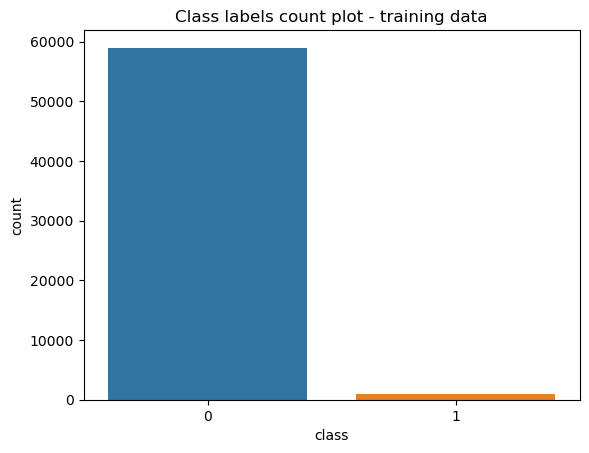

In [4]:
#Check unique values for 'class' feature - before mapping
print('class values before mapping: ', aps_train['class'].unique())

# Map class labels to 0 and 1
aps_train['class'] = aps_train['class'].map({'neg': 0, 'pos': 1})

#Check unique values for 'class' feature - after mapping
print('class values after mapping: ', aps_train['class'].unique())

# Count plot for class labels - training data
sns.countplot(x='class', data=aps_train)
plt.title('Class labels count plot - training data')
plt.show()

## 0 is neg - represents trucks with failures for components not related to the APS.
## 1 is pos - represents failures for the specific component considered.
## The plot below shows that most of the data is negative, only a very small proportion of the data is positive for 'class'.
## This imbalance may cause problems for the models.


In [5]:
#Check for missing values (includes NaN) - show all columns
print(aps_train.isnull().sum()) 

#Print dimensions after before handling missing values
rows, cols = aps_train.shape
print("Training data has {} rows with {} columns".format(rows, cols))

## Before handling missing values, the data has 171 features and 60000 rows

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64
Training data has 60000 rows with 171 columns


Missing values by percentage:
{'br_000': 82.10666666666667, 'bq_000': 81.20333333333333, 'bp_000': 79.56666666666666, 'bo_000': 77.22166666666666, 'ab_000': 77.215, 'cr_000': 77.215, 'bn_000': 73.34833333333333, 'bm_000': 65.915, 'bl_000': 45.461666666666666, 'bk_000': 38.39, 'ad_000': 24.768333333333334, 'cf_000': 24.768333333333334, 'cg_000': 24.768333333333334, 'ch_000': 24.768333333333334, 'co_000': 24.768333333333334, 'ct_000': 23.013333333333332, 'cu_000': 23.013333333333332, 'cv_000': 23.013333333333332, 'cx_000': 23.013333333333332, 'cy_000': 23.013333333333332, 'cz_000': 23.013333333333332, 'da_000': 23.013333333333332, 'db_000': 23.013333333333332, 'dc_000': 23.013333333333332, 'ec_00': 17.065, 'cm_000': 16.461666666666666, 'cl_000': 15.921666666666667, 'ed_000': 15.921666666666667, 'ak_000': 7.333333333333333, 'ca_000': 7.26, 'dm_000': 6.681666666666667, 'df_000': 6.68, 'dg_000': 6.68, 'dh_000': 6.68, 'dl_000': 6.68, 'dj_000': 6.678333333333334, 'dk_000': 6.678333333333334, 

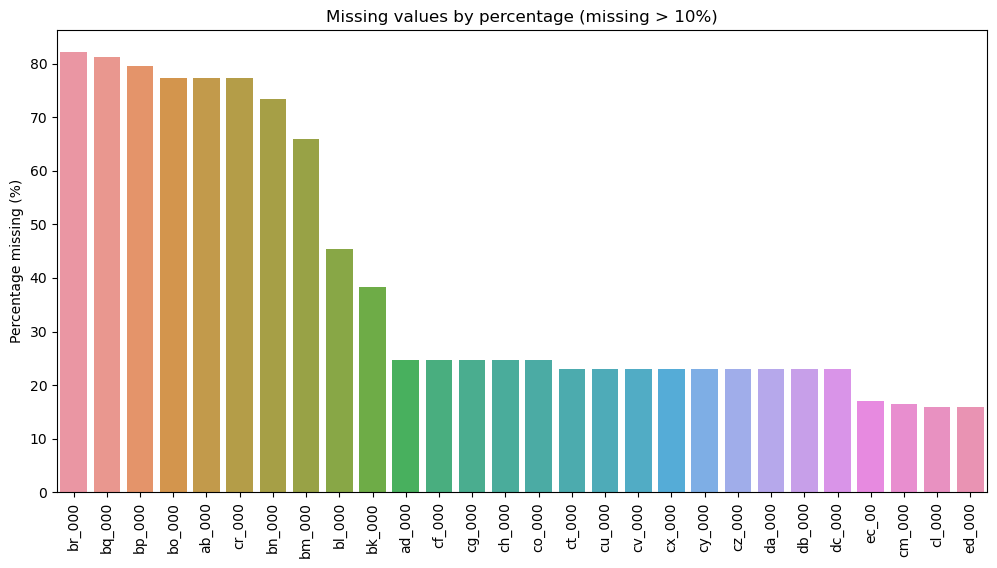

In [6]:
## Plot missing values by percentage

# Calculate percentages and sort missing values
missing = {key: list(aps_train.isna().sum()*100/aps_train.shape[0])[i] for i, key in enumerate(aps_train.columns)}
missing = dict(sorted(missing.items(), key=lambda x: x[1], reverse=True))

# Print missing values
print('Missing values by percentage:')
print(missing)

missing_high = {key: val for key, val in missing.items() if val > 10}
missing_low = {key: val for key, val in missing.items() if val < 10}

#Plot missing values where missing > 10%
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.title('Missing values by percentage (missing > 10%)')
plt.ylabel('Percentage missing (%)')
sns.barplot(x=list(missing_high.keys()), y=list(missing_high.values()))
plt.show()

## The plot shows that some features have a lot of missing values, and a lot of features have some missing values.
## 10 features have more than 30% missing values. 24 have more than 20% missing. 28 features have more than 10% missing values.
## Missing values will also impact the model and so will need to be handled in some way.

In [7]:
# Drop features with more than 70% missing values
print('Features with more than 70% missing values dropped from training data: \n', missing_high.keys())
aps_train.dropna(axis=1, thresh=0.7*aps_train.shape[0], inplace=True)

# Drop specific rows for features with less than 5% missing
under_5 = [k for k, v in missing.items() if v < 5]
print('\nFeatures with less than 5% missing values dropped from training data: \n', under_5)
aps_train.dropna(subset=under_5, inplace=True)

#Print dimensions after before handling missing values
rows, cols = aps_train.shape
print("\nTraining data now has {} rows with {} columns".format(rows, cols))

Features with more than 70% missing values dropped from training data: 
 dict_keys(['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000', 'bl_000', 'bk_000', 'ad_000', 'cf_000', 'cg_000', 'ch_000', 'co_000', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000', 'db_000', 'dc_000', 'ec_00', 'cm_000', 'cl_000', 'ed_000'])

Features with less than 5% missing values dropped from training data: 
 ['bd_000', 'ds_000', 'dt_000', 'dp_000', 'dq_000', 'dr_000', 'du_000', 'dv_000', 'bc_000', 'cp_000', 'de_000', 'do_000', 'dy_000', 'ef_000', 'ar_000', 'bz_000', 'dx_000', 'dz_000', 'ea_000', 'eg_000', 'be_000', 'dd_000', 'ce_000', 'ax_000', 'ae_000', 'af_000', 'av_000', 'bf_000', 'bs_000', 'cb_000', 'bu_000', 'bv_000', 'cq_000', 'dn_000', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'cd_000', 'ag_000', 'a

In [8]:
# Split the training data into X and y
X_train = aps_train.drop('class', axis=1)
y_train = aps_train['class']

# Print dimensions
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

# Standardise the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

print('scaled_X_train: ', scaled_X_train.shape)

X_train:  (55936, 160)
y_train:  (55936,)
scaled_X_train:  (55936, 160)


In [9]:
# Function to impute missing values using median for specified features and model-based imputation for the rest

def impute_missing_values(df, missing_col):
    """"
    Parameters:
        df (dataframe): Input dataframe with missing values.
        missing_col (list): List of feature names with missing values to be imputed.

    Returns:
        imputed_df (dataframe): Dataframe with missing values imputed.
        median_imputer (SimpleImputer): Median imputer instance.
        mice_imputer (IterativeImputer): Model-based imputer instance.
    """
    if df.empty:
        raise ValueError("Input dataframe is empty")
    if not missing_col:
        raise ValueError("Missing column list is empty")

    # Create median imputer instance
    median_imputer = SimpleImputer(strategy='median')

    median_df = median_imputer.fit_transform(df[missing_col])   # Impute missing values using column-wise medians
    temp = df.copy()                                            # Create a copy of the dataframe
    temp[missing_col] = median_df                               # Replace missing values in data_copy with imputed values from median_df

    # Create a model-based imputer using Ridge estimator for missing data
    mice_imputer = IterativeImputer(estimator=Ridge(random_state=0), random_state=0)

    # Impute missing values using model-based imputer (MICE)
    imputed_df = pd.DataFrame(data=mice_imputer.fit_transform(temp), columns=temp.columns)

    return imputed_df, median_imputer, mice_imputer

In [12]:
## Impute remaining missing values in training data

# Convert scaled_X_train to a dataframe
X_train_df = pd.DataFrame(scaled_X_train, columns=X_train.columns)

# Create a list of features with missing values between 5% to 15%
median_imputed_features = [k for k, v in missing.items() if v >= 5 and v < 15]

# Impute missing values for X_train_df, median_imputer and mice_imputer instances
imputed_X_train, median_imputer, mice_imputer = impute_missing_values(X_train_df, median_imputed_features)

#Print dimensions after imputing missing values
rows, cols = imputed_X_train.shape
print("Training data now has {} rows with {} columns".format(rows, cols))

Training data now has 55936 rows with 160 columns


_**Testing data**_

In [13]:
# Read in test data set - exclude first 20 rows of metadata
aps_test = pd.read_csv('aps_failure_test_set.csv', header=14, na_values=["na"])

# Print dimensions
rows, cols = aps_test.shape
print("Before cleaning - test data has {} rows with {} columns".format(rows, cols))

# Map class labels to 0 and 1
aps_test['class'] = aps_test['class'].map({'neg': 0, 'pos': 1})

# Show head
aps_test.head()

Before cleaning - test data has 16000 rows with 171 columns


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


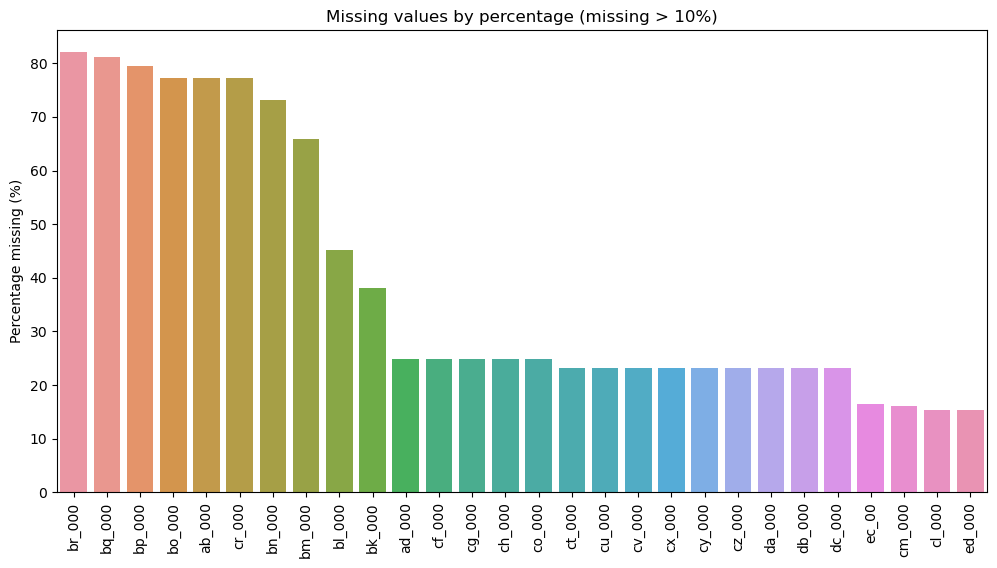

Features with more than 70% missing values dropped from training data: 
 dict_keys(['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000', 'bl_000', 'bk_000', 'ad_000', 'cf_000', 'cg_000', 'ch_000', 'co_000', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000', 'db_000', 'dc_000', 'ec_00', 'cm_000', 'cl_000', 'ed_000'])

Features with less than 5% missing values dropped from test data: 
 ['ar_000', 'bc_000', 'bd_000', 'de_000', 'do_000', 'dp_000', 'dq_000', 'dr_000', 'ds_000', 'dt_000', 'du_000', 'dv_000', 'dx_000', 'dy_000', 'bz_000', 'cp_000', 'dz_000', 'ea_000', 'ef_000', 'eg_000', 'ae_000', 'af_000', 'be_000', 'bf_000', 'av_000', 'ax_000', 'ce_000', 'dd_000', 'bs_000', 'cb_000', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_00

In [14]:
## Handle missing values in test data

# Calculate percentages and sort missing values
missing = {key: list(aps_test.isna().sum()*100/aps_test.shape[0])[i] for i, key in enumerate(aps_test.columns)}
missing = dict(sorted(missing.items(), key=lambda x: x[1], reverse=True))

missing_high = {key: val for key, val in missing.items() if val > 10}
missing_low = {key: val for key, val in missing.items() if val < 10}

# Plot missing values where missing > 10%
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.title('Missing values by percentage (missing > 10%)')
plt.ylabel('Percentage missing (%)')
sns.barplot(x=list(missing_high.keys()), y=list(missing_high.values()))
plt.show()

# Drop features with more than 70% missing values
print('Features with more than 70% missing values dropped from training data: \n', missing_high.keys())
aps_test.dropna(axis=1, thresh=0.7*aps_test.shape[0], inplace=True)

# Drop specific rows for features with less than 5% missing
under_5 = [k for k, v in missing.items() if v < 5]
print('\nFeatures with less than 5% missing values dropped from test data: \n', under_5)
aps_test.dropna(subset=under_5, inplace=True)

#Print dimensions after before handling missing values
rows, cols = aps_test.shape
print("\nTest data now has {} rows with {} columns".format(rows, cols))


In [15]:
# Split the testing data into X and y
X_test = aps_test.drop('class', axis=1)
y_test = aps_test['class']

# Standardise the data
scaler = StandardScaler()
scaled_X_test = scaler.fit_transform(X_test)

In [16]:
## Impute remaining missing values in test data

# Convert scaled_X_test to a dataframe
X_test_df = pd.DataFrame(scaled_X_test, columns=X_test.columns)

# Create a list of features with missing values between 5% to 15%
median_imputed_features = [k for k, v in missing.items() if v >= 5 and v < 15]

# Impute missing vlaues for X_train, median_imputer and mice_imputer instances
if scaled_X_test.size == 0:
    raise ValueError("Input array is empty")
imputed_X_test, median_imputer, mice_imputer = impute_missing_values(X_test_df, median_imputed_features)

#Print dimensions after imputing missing values
rows, cols = imputed_X_test.shape
print("Test data has {} rows with {} columns".format(rows, cols))

Test data has 14891 rows with 160 columns


_**Question 1: What is the mechanism used by the Voting Classifier to aggregate predictions from multiple base
models and their differences? Explain with suitable example. If predictions conflict among the base
models, what strategies can be employed to resolve the conflicts and make more reliable final
predictions in the Voting Classifier?**_

In [118]:
## Base models - logistic regression

# Parameters to tune
penalty = ['l1', 'l2', 'elasticnet', 'none'] # l1 is Lasso, l2 is Ridge
C = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['newton-cg', 'newton-cholesky', 'liblinear', 'sag', 'saga']

# Store best results
best_accuracy = 0 
best_params = {}

# Loop through parameters to find best model
for s, p, c in product(solver, penalty, C):
    # lbgfs, newton-cg, sag only take l2 or None penalty
    # liblinear only takes l1 or l2 penalty
    # saga takes all penalties
    if s == 'lbfgs' or s == 'newton-cg' or s=='sag' and p != 'l2' and p != 'none':
        continue
    if s == 'liblinear' or s == 'newton-cholesky' and p != 'l2' and p != 'none':
        continue
    if s == 'saga' and p == 'elasticnet': #this combo not working, not sure why
        continue
    log_reg = LogisticRegression(solver=s, penalty=p, random_state=42, C=c)
    log_reg.fit(imputed_X_train, y_train)
    y_pred = log_reg.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For solver={s}, penalty={p}, C={c}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'solver': s, 'penalty': p, 'C': c}

# Loop through parameters to find best model - only run for lbgfs this time
penalty = ['l2', 'none']
solver = ['lbfgs']
for s, p, c in product(solver, penalty, C):
    log_reg = LogisticRegression(solver=s, penalty=p, C=c, random_state=42)
    log_reg.fit(imputed_X_train, y_train)
    y_pred = log_reg.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For solver={s}, penalty={p}, C={c}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'solver': s, 'penalty': p, 'C': c}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 10}
# Best accuracy: 0.993

For solver=newton-cholesky, penalty=l2, C=0.001, model accuracy is 0.990
For solver=newton-cholesky, penalty=l2, C=0.01, model accuracy is 0.992
For solver=newton-cholesky, penalty=l2, C=0.1, model accuracy is 0.992
For solver=newton-cholesky, penalty=l2, C=1, model accuracy is 0.993
For solver=newton-cholesky, penalty=l2, C=10, model accuracy is 0.993
For solver=newton-cholesky, penalty=l2, C=100, model accuracy is 0.992
For solver=newton-cholesky, penalty=none, C=0.001, model accuracy is 0.992
For solver=newton-cholesky, penalty=none, C=0.01, model accuracy is 0.992
For solver=newton-cholesky, penalty=none, C=0.1, model accuracy is 0.992
For solver=newton-cholesky, penalty=none, C=1, model accuracy is 0.992
For solver=newton-cholesky, penalty=none, C=10, model accuracy is 0.992
For solver=newton-cholesky, penalty=none, C=100, model accuracy is 0.992
For solver=sag, penalty=l2, C=0.001, model accuracy is 0.990
For solver=sag, penalty=l2, C=0.01, model accuracy is 0.990
For solver=sag,

In [17]:
# Optimally tuned logistic regression model
log_reg = LogisticRegression(solver='newton-cholesky', penalty='l2', C=10, random_state=42)
log_reg.fit(imputed_X_train, y_train)
y_pred = log_reg.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred))

## Accuracy: 0.993

Accuracy:  0.993

Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.81      0.66      0.73       222

    accuracy                           0.99     14891
   macro avg       0.90      0.83      0.86     14891
weighted avg       0.99      0.99      0.99     14891



In [120]:
## Base model - RandomForestClassifier

# Parameters to tune
#n_estimators = [10, 20, 50, 100, 500, 1000, 2000] # runtime too long, running in next cell instead
criterion = ['gini', 'entropy', 'log_loss']
max_features = ['sqrt', 'log2', None]

# Store best results
best_accuracy = 0 
best_params = {}

# Loop through parameters to find best model
for c, m in product(criterion, max_features):
    rand_forest = RandomForestClassifier(criterion=c, max_features=m, random_state=42)
    rand_forest.fit(imputed_X_train, y_train)
    y_pred = rand_forest.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For criterion={c}, max_features={m}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'criterion': c, 'max_features': m}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

## Best hyperparameters: {'criterion': 'gini', 'max_features': None}
## Best accuracy: 0.993

For criterion=gini, max_features=sqrt, model accuracy is 0.993
For criterion=gini, max_features=log2, model accuracy is 0.993
For criterion=gini, max_features=None, model accuracy is 0.993
For criterion=entropy, max_features=sqrt, model accuracy is 0.993
For criterion=entropy, max_features=log2, model accuracy is 0.992
For criterion=entropy, max_features=None, model accuracy is 0.993
For criterion=log_loss, max_features=sqrt, model accuracy is 0.993
For criterion=log_loss, max_features=log2, model accuracy is 0.992
For criterion=log_loss, max_features=None, model accuracy is 0.993

Best hyperparameters: {'criterion': 'gini', 'max_features': None}
Best accuracy: 0.993


In [122]:
## Base model - RandomForestClassifier - n_estimators

# Parameters to tune
n_estimators = [10, 50, 100, 1000]
criterion = ['gini']
max_features = [None]

# Store best results
best_accuracy = 0 
best_params = {}

# Loop through parameters to find best model
for n, c, m in product(n_estimators, criterion, max_features):
    rand_forest = RandomForestClassifier(n_estimators=n, criterion=c, max_features=m, random_state=42)
    rand_forest.fit(imputed_X_train, y_train)
    y_pred = rand_forest.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For n_estimators={n}, criterion={c}, max_features={m}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'n_estimators': n, 'criterion': c, 'max_features': m}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'n_estimators': 2000, 'criterion': 'gini', 'max_features': None}
# Best accuracy: 0.994

For n_estimators=10, criterion=gini, max_features=None, model accuracy is 0.992
For n_estimators=50, criterion=gini, max_features=None, model accuracy is 0.993
For n_estimators=100, criterion=gini, max_features=None, model accuracy is 0.993
For n_estimators=1000, criterion=gini, max_features=None, model accuracy is 0.994

Best hyperparameters: {'n_estimators': 1000, 'criterion': 'gini', 'max_features': None}
Best accuracy: 0.994


In [18]:
# Optimally tuned random forest model
rand_forest = RandomForestClassifier(n_estimators=1000, criterion='gini', max_features=None, random_state=42)
rand_forest.fit(imputed_X_train, y_train)
y_pred = rand_forest.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred))

## Accuracy: 0.994

Accuracy:  0.994

Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.90      0.66      0.76       222

    accuracy                           0.99     14891
   macro avg       0.95      0.83      0.88     14891
weighted avg       0.99      0.99      0.99     14891



In [19]:
# Run and fit VotingClassifier using hard voting
voting_clf_hard = VotingClassifier(estimators=[('log_reg', log_reg), ('rand_forest', rand_forest)], voting='hard')
voting_clf_hard.fit(imputed_X_train, y_train)
y_pred_hard = voting_clf_hard.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred_hard))

## Accuracy: 0.993 


In [ ]:
# Function to calculate cost of misclassification (based on confusion matrix from https://archive.ics.uci.edu/dataset/421/aps+failure+at+scania+trucks)
def calculate_total_cost(y_true, y_pred, cost_1=10, cost_2=500):
    '''
    Calculate the total cost based on the confusion matrix and specified costs.

    Parameters:
    - y_true: True labels
    - y_pred_soft: Predicted labels
    - cost_1: Cost associated with false positives (default: 10)
    - cost_2: Cost associated with false negatives (default: 500)

    Returns:
    - total_cost: Total cost
    '''

    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
    total_cost = cost_1 * false_pos + cost_2 * false_neg
    return total_cost

In [ ]:
## Predict cost of misclassification (hard voting) - using function

print('Total cost: $', calculate_total_cost(y_test, y_pred_hard))

In [ ]:
## Predict cost of misclassification - using voting_clf_hard

Cost_1 = 10
Cost_2 = 500

true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred_hard).ravel()

# Print total cost
# Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances
print('Total cost: $', (Cost_1*false_pos + Cost_2*false_neg))

Total cost: $ 49100


In [ ]:
# Run and fit VotingClassifier using soft voting
voting_clf_soft = VotingClassifier(estimators=[('log_reg', log_reg), ('rand_forest', rand_forest)], voting='soft')
voting_clf_soft.fit(imputed_X_train, y_train)
y_pred_soft = voting_clf_soft.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred_soft))

## Accuracy: 0.993

Accuracy:  0.994

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14669
           1       0.85      0.68      0.75       222

    accuracy                           0.99     14891
   macro avg       0.92      0.84      0.88     14891
weighted avg       0.99      0.99      0.99     14891



In [ ]:
## Predict cost of misclassification (soft voting) - using function

print('Total cost: $', calculate_total_cost(y_test, y_pred_soft))

In [ ]:
## Predict cost of misclassification (soft voting)

Cost_1 = 10
Cost_2 = 500

true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred_soft).ravel()

# Print total cost
# Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances
print('Total cost: $', (Cost_1*false_pos + Cost_2*false_neg))


Total cost: $ 36260


Question 2. Can Support Vector Machine (SVM) effectively perform multiclass classification? If so, explain
the approach and techniques for successful implementation. If not, clarify the limitations or
challenges that restrict SVM's suitability for multiclass classification tasks

In [129]:
# SVM

# Parameters to tune
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_values = [10, 100, 1000]

# Store best results
best_accuracy = 0 
best_params = {}

# Loop through parameters to find best combination
for k, g in product(kernel, gamma_values):
    svc = SVC(kernel=k, gamma=g, random_state=42)
    svc.fit(imputed_X_test, y_test)
    y_pred = svc.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For kernel={k}, gamma={g}, model accuracy is {accuracy:.3f}")

    # Compate accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'kernel': k, 'gamma': g}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'kernel': 'poly', 'gamma': 10}
# Best accuracy: 1.000

## rbf and poly are possibly overfit (both with an accuracy of 1.00)
## Considering this, linear is the best kernel here (accuracy = 0.996)

For kernel=linear, gamma=10, model accuracy is 0.996
For kernel=linear, gamma=100, model accuracy is 0.996
For kernel=linear, gamma=1000, model accuracy is 0.996
For kernel=poly, gamma=10, model accuracy is 1.000
For kernel=poly, gamma=100, model accuracy is 1.000
For kernel=poly, gamma=1000, model accuracy is 1.000
For kernel=rbf, gamma=10, model accuracy is 1.000
For kernel=rbf, gamma=100, model accuracy is 1.000
For kernel=rbf, gamma=1000, model accuracy is 1.000
For kernel=sigmoid, gamma=10, model accuracy is 0.971
For kernel=sigmoid, gamma=100, model accuracy is 0.971
For kernel=sigmoid, gamma=1000, model accuracy is 0.971

Best hyperparameters: {'kernel': 'poly', 'gamma': 10}
Best accuracy: 1.000


In [ ]:
# Optimally tuned SVC model

svc = SVC(kernel='linear', gamma=10, random_state=42)
svc.fit(imputed_X_train, y_train)

y_pred = svc.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred))

## Accuracy = 0.993

Accuracy:  0.993

Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.91      0.57      0.70       222

    accuracy                           0.99     14891
   macro avg       0.95      0.78      0.85     14891
weighted avg       0.99      0.99      0.99     14891



Question 3. Analyse the importance of the features for predicting “class” using two different approaches.
Explain the similarity/difference between outcomes

In [ ]:
##First approach - Feature importance with logistic regression (L2 regularisation/Ridge)

# Run logistic regression with L2 regularisation
logistic = LogisticRegression(penalty='l2', random_state=42).fit(imputed_X_train, y_train)
log_pred = logistic.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, log_pred), 3))
print(classification_report (y_test, log_pred)) 

Accuracy:  0.992
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.81      0.62      0.70       222

    accuracy                           0.99     14891
   macro avg       0.90      0.81      0.85     14891
weighted avg       0.99      0.99      0.99     14891



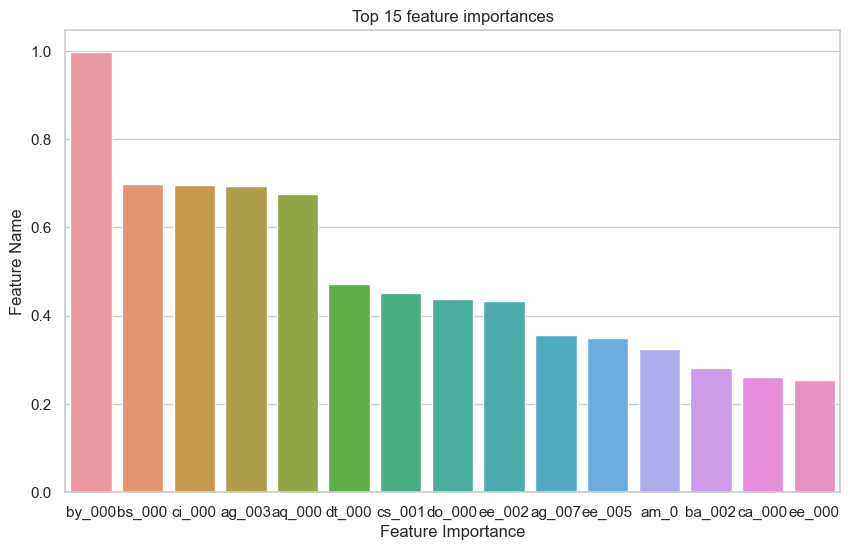

In [ ]:
# Plot top 15 feature importances
feat_importances = pd.Series(logistic.coef_[0], index=X_train.columns)
top_features_lr = feat_importances.nlargest(15)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_lr.index, y=top_features_lr)
plt.title("Top 15 feature importances")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

In [ ]:
## Second approach - Feature importance using random forest classifier

# Run random forest classifier
rand_forest = RandomForestClassifier(n_estimators=10, random_state=42)
rand_forest.fit(imputed_X_train, y_train)
y_pred = rand_forest.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print(classification_report (y_test, y_pred))

Accuracy:  0.992
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.87      0.53      0.66       222

    accuracy                           0.99     14891
   macro avg       0.93      0.76      0.83     14891
weighted avg       0.99      0.99      0.99     14891



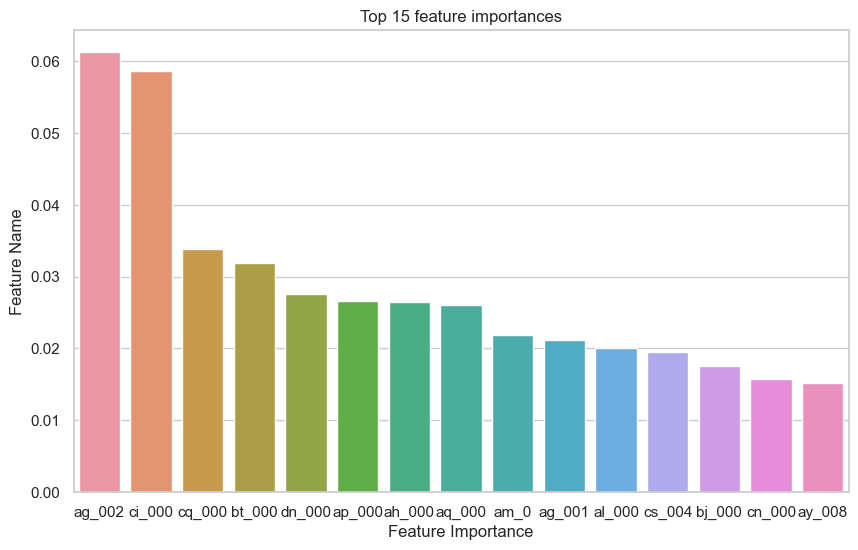

In [ ]:
# Plot top 15 feature importances

importances = rand_forest.feature_importances_
forest_importances = pd.Series(importances, index=list(imputed_X_train.columns))
top_features_rf = forest_importances.nlargest(15)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_rf.index, y=top_features_rf)
plt.title("Top 15 feature importances")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()


In [ ]:
# Compare top features from both approaches
print("Top features from logistic regression: \n", top_features_lr)
print("\nTop features from random forest: \n", top_features_rf)

## As shown by the plots above and the printed top features for each approach below, the top 15 features are different for logistic regression and for random forest classifier.
## This could be to do with differences in how each model works. Logistic regression is a linear model that makes predictions by assigning weights to each feature.
## Random forest classifier makes predictions based on the average of multiple decision trees. 
## Both methods produced the same accuracy score (0.992).

Top features from logistic regression: 
 by_000    0.997139
bs_000    0.699070
ci_000    0.696384
ag_003    0.694032
aq_000    0.674741
dt_000    0.472447
cs_001    0.451924
do_000    0.438330
ee_002    0.432007
ag_007    0.355793
ee_005    0.349276
am_0      0.324573
ba_002    0.281319
ca_000    0.261666
ee_000    0.253367
dtype: float64

Top features from random forest: 
 ag_002    0.061255
ci_000    0.058572
cq_000    0.033826
bt_000    0.031920
dn_000    0.027551
ap_000    0.026565
ah_000    0.026414
aq_000    0.026070
am_0      0.021921
ag_001    0.021144
al_000    0.020010
cs_004    0.019429
bj_000    0.017478
cn_000    0.015667
ay_008    0.015221
dtype: float64


Question 4. Create three supervised machine learning (ML) models except any ensemble approach for
predicting "class"

In [ ]:
## Supervised ML model one - Decision tree

# Parameters to tune
criterion = ['gini', 'entropy']
max_depth = [2, 5, 10, 20, 50, 100, None]

# Best results
best_accuracy = 0
best_params = {}

# Loop through parameters to find best model
for c, m in product(criterion, max_depth):
    decision_tree = DecisionTreeClassifier(criterion=c, max_depth=m, random_state=42)
    decision_tree.fit(imputed_X_train, y_train)
    y_pred = decision_tree.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For criterion={c}, max_depth={m}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'criterion': c, 'max_depth': m}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'criterion': 'gini', 'max_depth': 10}
# Best accuracy: 0.991

For criterion=gini, max_depth=2, model accuracy is 0.988
For criterion=gini, max_depth=5, model accuracy is 0.991
For criterion=gini, max_depth=10, model accuracy is 0.991
For criterion=gini, max_depth=20, model accuracy is 0.990
For criterion=gini, max_depth=50, model accuracy is 0.965
For criterion=gini, max_depth=100, model accuracy is 0.965
For criterion=gini, max_depth=None, model accuracy is 0.965
For criterion=entropy, max_depth=2, model accuracy is 0.989
For criterion=entropy, max_depth=5, model accuracy is 0.990
For criterion=entropy, max_depth=10, model accuracy is 0.988
For criterion=entropy, max_depth=20, model accuracy is 0.735
For criterion=entropy, max_depth=50, model accuracy is 0.735
For criterion=entropy, max_depth=100, model accuracy is 0.735
For criterion=entropy, max_depth=None, model accuracy is 0.735

Best hyperparameters: {'criterion': 'gini', 'max_depth': 10}
Best accuracy: 0.991


In [ ]:
# Decision with with best hyperparameters
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
decision_tree.fit(imputed_X_train, y_train)
y_pred = decision_tree.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print(classification_report (y_test, y_pred))

Accuracy:  0.991
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.82      0.51      0.63       222

    accuracy                           0.99     14891
   macro avg       0.91      0.76      0.81     14891
weighted avg       0.99      0.99      0.99     14891



In [ ]:
## Supervised ML model two - Logistic regression (using optimised hyperparameters found in Q1)

# Run logistic regression with newton-cholesky solver and L2 regularisation
log_reg = LogisticRegression(solver='newton-cholesky', penalty='l2', C=10, random_state=42)
log_reg.fit(imputed_X_train, y_train)
y_pred = log_reg.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred))

Accuracy:  0.993

Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.81      0.66      0.73       222

    accuracy                           0.99     14891
   macro avg       0.90      0.83      0.86     14891
weighted avg       0.99      0.99      0.99     14891



In [ ]:
## Supervised ML model three - Naive Bayes

# Parameters to tune
priors = [None]
smoothing = [1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09]

# Best results
best_accuracy = 0
best_params = {}

# Loop through parameters to find best model
for p, s in product(priors, smoothing):
    naive_bayes = GaussianNB(priors=p, var_smoothing=s)
    naive_bayes.fit(imputed_X_train, y_train)
    y_pred = naive_bayes.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For priors={p}, smoothing={s}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'priors': p, 'smoothing': s}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'priors': None, 'smoothing': 1.0}
# Best accuracy: 0.985

For priors=None, smoothing=1.0, model accuracy is 0.985
For priors=None, smoothing=0.1, model accuracy is 0.981
For priors=None, smoothing=0.01, model accuracy is 0.977
For priors=None, smoothing=0.001, model accuracy is 0.979
For priors=None, smoothing=0.0001, model accuracy is 0.981
For priors=None, smoothing=1e-05, model accuracy is 0.983
For priors=None, smoothing=1e-06, model accuracy is 0.985
For priors=None, smoothing=1e-07, model accuracy is 0.985
For priors=None, smoothing=1e-08, model accuracy is 0.985
For priors=None, smoothing=1e-09, model accuracy is 0.985

Best hyperparameters: {'priors': None, 'smoothing': 1.0}
Best accuracy: 0.985


In [ ]:
## Naive bayes model with optimised hyperparamters

# Naive Bayes classifier
naive_bayes = GaussianNB(priors=None, var_smoothing=1.0) # change here
naive_bayes.fit(imputed_X_train, y_train)
y_pred = naive_bayes.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print(classification_report (y_test, y_pred))

## Accuracy:  0.985

Accuracy:  0.985
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14669
           1       0.52      0.40      0.45       222

    accuracy                           0.99     14891
   macro avg       0.75      0.70      0.72     14891
weighted avg       0.98      0.99      0.98     14891



Question 5. Build three ensemble models including voting classifier for predicting “class”.

a. When do you want to use ensemble models over other ML models? Explain based on the
models that you have used in Q4 and Q5.

b. What are the similarities or differences between among used ensemble models in Q5?

c. Is there any preferable scenario for using any specific model among the set of ensemble
models? Explain based on obtained outcomes.

d. Write a report comparing performances of models built in question 4 and 5. Report the best
method based on model complexity and performance.

e. Is it possible to build ensemble model using ML classifiers other than decision tree? If yes,
then explain with an example. 

In [ ]:
## Ensemble model 1 - AdaBoost

# Parameters to tune
n_estimators = [50, 100, 200, 500, 1000]
learning_rate = [0.001, 0.01, 0.1, 1, 10]

# Best results
best_accuracy = 0
best_params = {}

# Loop through parameters to find best model
for n, l in product(n_estimators, learning_rate):
    ada_boost = AdaBoostClassifier(n_estimators=n, learning_rate=l, random_state=42)
    ada_boost.fit(imputed_X_train, y_train)
    y_pred = ada_boost.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For n_estimators={n}, learning_rate={l}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'n_estimators': n, 'learning_rate': l}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'n_estimators': 500, 'learning_rate': 1}
# Best accuracy: 0.992

For n_estimators=50, learning_rate=0.001, model accuracy is 0.985
For n_estimators=50, learning_rate=0.01, model accuracy is 0.985
For n_estimators=50, learning_rate=0.1, model accuracy is 0.988
For n_estimators=50, learning_rate=1, model accuracy is 0.989
For n_estimators=50, learning_rate=10, model accuracy is 0.985
For n_estimators=100, learning_rate=0.001, model accuracy is 0.985
For n_estimators=100, learning_rate=0.01, model accuracy is 0.985
For n_estimators=100, learning_rate=0.1, model accuracy is 0.989
For n_estimators=100, learning_rate=1, model accuracy is 0.990
For n_estimators=100, learning_rate=10, model accuracy is 0.985
For n_estimators=200, learning_rate=0.001, model accuracy is 0.985
For n_estimators=200, learning_rate=0.01, model accuracy is 0.985
For n_estimators=200, learning_rate=0.1, model accuracy is 0.990
For n_estimators=200, learning_rate=1, model accuracy is 0.991
For n_estimators=200, learning_rate=10, model accuracy is 0.985
For n_estimators=500, learning

In [ ]:
## AdaBoost with tuned hyperparameters

ada_boost = AdaBoostClassifier(n_estimators=500, learning_rate=1, random_state=42)
ada_boost.fit(imputed_X_train, y_train)
y_pred = ada_boost.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print(classification_report (y_test, y_pred))

## Accuracy:  0.992

NameError: name 'imputed_X_train' is not defined

In [146]:
## Ensemble model 2 - MLP

# Parameters to tune
hidden_layer_sizes = [(10,10,10,10,10,10,10,10,10,10),
                      (25,25,25,25,25,25,25,25,25,25),
                      (100,100,100,100,100,100,100,100,100,100)]
activation = ['identity', 'logistic', 'tanh', 'relu']

# Best results
best_accuracy = 0
best_params = {}

# Loop through parameters to find best model
for h, a in product(hidden_layer_sizes, activation):
    mlp = MLPClassifier(hidden_layer_sizes=h, activation=a, random_state=42)
    mlp.fit(imputed_X_train, y_train)
    y_pred = mlp.predict(imputed_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"For hidden_layer_sizes={h}, activation={a}, model accuracy is {accuracy:.3f}")

    # Compare accuracy to current best, replace if higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'hidden_layer_sizes': h, 'activation': a}

# Print the best hyperparameter combo and accuracy for that combo
print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.3f}")

# Best hyperparameters: {'hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100), 'activation': 'relu'}
# Best accuracy: 0.994

For hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), activation=identity, model accuracy is 0.992
For hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), activation=logistic, model accuracy is 0.985
For hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), activation=tanh, model accuracy is 0.982
For hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), activation=relu, model accuracy is 0.992
For hidden_layer_sizes=(25, 25, 25, 25, 25, 25, 25, 25, 25, 25), activation=identity, model accuracy is 0.991
For hidden_layer_sizes=(25, 25, 25, 25, 25, 25, 25, 25, 25, 25), activation=logistic, model accuracy is 0.985
For hidden_layer_sizes=(25, 25, 25, 25, 25, 25, 25, 25, 25, 25), activation=tanh, model accuracy is 0.990
For hidden_layer_sizes=(25, 25, 25, 25, 25, 25, 25, 25, 25, 25), activation=relu, model accuracy is 0.992
For hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100, 100), activation=identity, model accuracy is 0.992
For hidden_layer

In [ ]:
# Optimally tuned MLP model

mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100, 100), activation='relu', random_state=42)
mlp.fit(imputed_X_train, y_train)
y_pred = mlp.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print(classification_report (y_test, y_pred))

## Accuracy = 0.994

Accuracy:  0.994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14669
           1       0.86      0.68      0.76       222

    accuracy                           0.99     14891
   macro avg       0.93      0.84      0.88     14891
weighted avg       0.99      0.99      0.99     14891



In [ ]:
## Ensemble model 3 - Random forest (using optimal hyperparameters found in Q1)

# Optimally tuned random forest model
rand_forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_features=None, random_state=42)
rand_forest.fit(imputed_X_train, y_train)
y_pred = rand_forest.predict(imputed_X_test)

# Performance metrics
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 3))
print('\nClassification report: \n', classification_report(y_test, y_pred))

Accuracy:  0.994

Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     14669
           1       0.89      0.65      0.75       222

    accuracy                           0.99     14891
   macro avg       0.94      0.83      0.88     14891
weighted avg       0.99      0.99      0.99     14891

